## Logistic regression and stochastic gradient descent algorithms
We will learn how to programme the logistic regression (LR) model. To find the best fitting parameters in the LR, gradient descent (GD) and stochastic gradient descent (SGD) can be used.

In [1]:
# These modules are required for this exercise.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### 1. We start from a toy data. The following is to generate a data for demonstrating the logistic regression model for binary classification. We will use the gradient descent algorithm and the stochastic gradient descent algorithm to optimize the model parameters.

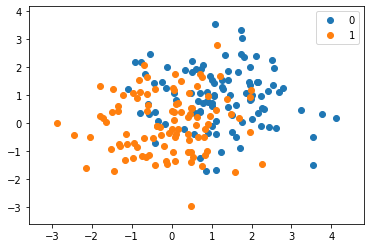

In [2]:
# class 1
s1 = pd.DataFrame(np.random.randn(100,2))
y1 = np.int32(np.ones(100))

# class 2
s2 = pd.DataFrame(np.random.randn(100,2)+ 1.0) 
y2 = np.int32(0.0*np.ones(100))
subdata=pd.concat([s1, s2],axis=0, ignore_index=True)
subdata.columns = ['x1','x2']
y = pd.Series(np.concatenate([y1,y2]))
subdata['class'] = pd.Series(y)
#pd.set_option('display.max_rows', None)

groups = subdata.groupby('class')
# scatter plots
fig, ax = plt.subplots()
ax.margins(0.1)
for name, group in groups:    
    ax.plot(group.x1,group.x2,marker='o',linestyle='',label=name)
ax.legend()


### 1.1) Our task is to train a LR classifier using the following data, where X is the feature data and Y the corresponding class labels. Note that since we are going to use gradient descent algorithm, I'd like to use TensorFlow to represent all the variables.

In [3]:
X = tf.constant(subdata.values[:,0:2], dtype=tf.float32)
Y = tf.constant(subdata.values[:,-1], shape=(len(subdata.index),1), dtype=tf.float32)
#print(X)
#print(Y)

### 1.2) Firstly, we want to compute the log odds of class 1 (or the logit function). Write a function to accomplish this small task.

In [4]:
def logits(X,w):    
    return tf.linalg.matmul(X,w) # X has shape (N,m); w has shape (m,1)

# test it
w = tf.Variable(initial_value=[[0.5],[1]],shape=(2,1), dtype=tf.float32)
#print(logits(X,w))

### 1.3) Secondly, we want to compute the negative sigmoid cross entropy. Again write a function to accomplish it.

In [5]:
def loss(X,Y,w):
    return tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=logits(X,w)))

# test it
w = tf.Variable(initial_value=[[0.5],[1]],shape=(2,1), dtype=tf.float32)
print(loss(X,Y,w))

tf.Tensor(269.3537, shape=(), dtype=float32)


### 1.4) Thirdly, since the objective function, i.e., the loss function, has been defined, the gradient is now needed for using gradient descent algorithm.
### So we can use TensorFlow's GradientTape to automatically compute the gradients
### In the following, write a function to returen the gradient given the variable w.

In [6]:
# compute the gradient 
def w_grad(w,X,Y):
    with tf.GradientTape() as tape:
        tape.watch(w)
        loss_fun = loss(X,Y,w)
    return tape.gradient(loss_fun,w)

# test it
w = tf.Variable(initial_value=[[1.0],[1.0]],shape=(2,1), dtype=tf.float32)
grad = w_grad(w,X,Y)
print(grad)

tf.Tensor(
[[138.6882 ]
 [107.88237]], shape=(2, 1), dtype=float32)


### 1.5) Finally, the parameter w can be learning using gradient descent, given an initial value for w, the gradient, and the data.

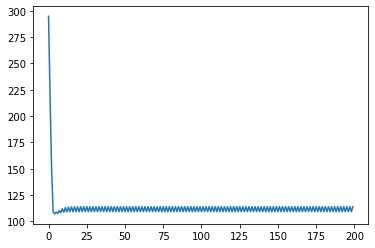

In [7]:
# use gradient descent to update w
Iters = 200
eta = 0.05
Loss = []
w = tf.Variable(initial_value=[[2.0],[2.0]],shape=(2,1), dtype=tf.float32)
Weights = tf.identity(w) # to store the w at each iteration
for i in range(Iters):
    Weights = tf.concat([Weights,w],1)
    w = w - eta*w_grad(w,X,Y)
    Loss.append(loss(X,Y,w).numpy())

#print(Weights)
plt.plot(Loss)

### 1.6) We have done gradient descent algorithm. Now we want to use SGD to learn w instead.
### Firstly, we need to write a function to automatically create mini-batches to feed data to SGD

In [8]:
# to create mini-batches
def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    #data = np.hstack((X, y)) 
    data = np.transpose(np.vstack((X_data,y_data)))
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
  
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    return mini_batches 

# test it
X_data = np.transpose(X.numpy())
y_data = np.transpose(Y.numpy())
mini_batches = create_mini_batches(X_data, y_data, 2)
print(mini_batches[0])

(array([[1.6747663 , 0.17933692],
       [0.50487334, 1.8296919 ]], dtype=float32), array([[1.],
       [0.]], dtype=float32))


### 1.7) Secondly, we now can programme the SGD to learn w by using mini-batch data.

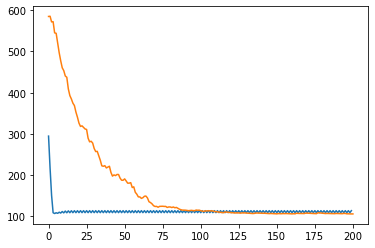

tf.Tensor(
[[-0.8404252 ]
 [-0.32654464]], shape=(2, 1), dtype=float32)


In [9]:
# Stochastic gradient descent
# use stochastic gradient descent to update w
Iters = 1
eta = 0.05
Loss_mini = []
w = tf.Variable(initial_value=[[2.0],[2.0]],shape=(2,1), dtype=tf.float32)
Weights = tf.identity(w)
for i in range(Iters):
    mini_batches = create_mini_batches(X_data, y_data, 1)
    for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        Weights = tf.concat([Weights,w],1)
        w = w - eta*w_grad(w,X_mini,y_mini)
        z = logits(X,w)
        Loss_mini.append(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=z)).numpy())

# test it
plt.plot(Loss)
plt.plot(Loss_mini)
plt.show()
print(w)

## Prediction
### The trained model can be used for prediction

### 2.1) Generate a test data

In [10]:
# generate test data
# class 1
s1 = pd.DataFrame(np.random.randn(100,2))
y1 = np.int32(np.ones(100))

# class 2
s2 = pd.DataFrame(np.random.randn(100,2)+ 1.0) 
y2 = np.int32(0.0*np.ones(100))
test_X=pd.concat([s1, s2],axis=0, ignore_index=True)
test_X.columns = ['x1','x2']
test_Y = pd.Series(np.concatenate([y1,y2]))
#subdata['class'] = pd.Series(test_Y)
test_X = tf.constant(test_X.values, dtype=tf.float32)
#print(test_X)
test_Y = tf.constant(test_Y.values, dtype=tf.float32)
print(test_Y)

tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(200,), dtype=float32)


### 2.2) Define the sigmoid function

In [11]:
def sigmoid(X,w):
    return tf.math.sigmoid(logits(X,w))

### 2.3) Compute the predicted labels for the test data

In [12]:
# test it
prob = tf.squeeze(sigmoid(test_X,w))
threshold = 0.5
pred_Y = tf.greater(prob,threshold)
print(pred_Y)


tf.Tensor(
[ True False False  True  True False False False  True  True False  True
 False False False  True False  True  True  True False False  True  True
  True  True  True  True  True  True  True False  True False  True  True
 False  True False  True  True  True False  True False  True False False
 False  True False  True  True False False False  True False  True  True
 False  True  True  True False  True  True  True  True  True  True False
 False  True False  True  True  True False False  True False False False
  True False  True False  True False False False  True  True  True  True
 False  True  True  True False False  True False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False  True
 False False False False  True False False False False False False False
 False False False False False False Fal

### 2.4) Compute the confusion matrix

In [16]:
c_matrix = tf.math.confusion_matrix(test_Y,pred_Y)
print(c_matrix)

tf.Tensor(
[[94  6]
 [42 58]], shape=(2, 2), dtype=int32)


### 2.5) Draw the ROC curve

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = metrics.roc_curve(test_Y, prob)
#print(fpr)
#print(tpr)
#print(thresholds)

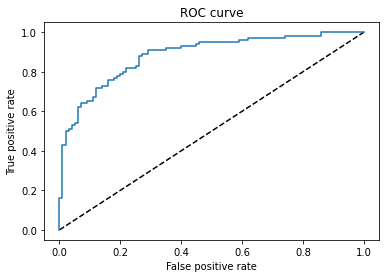

In [22]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR-SGD')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend(loc='best')
plt.show()

## 2. In the following, can you apply the previous GD and SGD to a real world data. The following Pima Indians Diabetes data has 8 features. We want to learn a LR classifier for classification purpose. The data information is provided.

In [ ]:
# read the csv file for the Pima Indians Diabetes

colnames = ['f1','f2','f3','f4','f5','f6','f7','f8','class']
data = pd.read_csv("pima-indians-diabetes.csv",names=colnames,header=None)
data.head(5)

# lets visualize two columns
subdata = data[['f3','f4','class']]
groups = subdata.groupby('class')

# scatter plots
fig, ax = plt.subplots()
ax.margins(0.1)
for name, group in groups:    
    ax.plot(group.f3,group.f4,marker='o',linestyle='',label=name)
ax.legend()

subdata.head(5)